In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import time

from rslds import RSLDS

In [2]:
class RSLDS(nn.Module):
    def __init__(self, N, K, H, C_syn, device):
        super().__init__()

        self.K = K
        self.C_syn = C_syn
        self.in_no = C_syn.shape[1]
        self.device = device
        self.N = N
        self.H = H
        
        self.W_zu = nn.Parameter(torch.randn(N, K, K)*0.01)
        self.W_zx = nn.Parameter(torch.randn(N, K, K, H)*0.01)
        self.W_xx = nn.Parameter(torch.randn(N, K, H, H)*0.01)
        self.W_xu = nn.Parameter(torch.randn(N, K, H)*0.01)
        self.W_yx = nn.Linear(N*H, 1)

        self.b_z = nn.Parameter(torch.randn(N, K, K)*0.01)
        self.b_x = nn.Parameter(torch.randn(N, K, H)*0.01)

        self.U_scale = nn.Parameter(torch.ones(self.in_no))
        self.Z_init = nn.Parameter(torch.zeros(N, K))
        
    def forward(self, U_raw, temp):
        # U_raw is (batch, T, in_no)
        batch = U_raw.shape[0]
        T = U_raw.shape[1]
        
        U_scaled = U_raw * self.U_scale.reshape(1, 1,-1)
        U = torch.matmul(U_scaled, self.C_syn.T) # (batch, T, N)
        
        Z_out = torch.zeros(batch, T+1, self.N, self.K).to(self.device)
        X_out = torch.zeros(batch, T+1, self.N, self.H).to(self.device)
        Z_out[:,0,:,:] = Z_out[:,0,:,:] + F.softmax(self.Z_init / temp, -1)
        
        for t in range(T):
            W_zu_part = torch.sum(self.W_zu.unsqueeze(0) * Z_out[:,t,:,:].clone().unsqueeze(-1), -2) #(batch,N,K)
            W_zx_part = torch.sum(self.W_zx.unsqueeze(0) * Z_out[:,t,:,:].clone().unsqueeze(-1).unsqueeze(-1), -3) #(batch,N,K,H)
            b_z_part = torch.sum(self.b_z.unsqueeze(0) * Z_out[:,t,:,:].clone().unsqueeze(-1) , -2) #(batch,N,K)
            
            Z_curr_raw = torch.matmul(W_zx_part , X_out[:,t,:,:].clone().unsqueeze(-1)).squeeze(-1) \
                + W_zu_part * U[:,t,:].unsqueeze(-1) + b_z_part
            Z_curr = F.softmax(Z_curr_raw / temp, -1) # (batch,N,K)
            Z_out[:,t+1,:,:] = Z_out[:,t+1,:,:] + Z_curr
            
            W_xu_part = torch.sum(self.W_xu.unsqueeze(0) * Z_curr.unsqueeze(-1), -2) #(batch,N,H)
            W_xx_part = torch.sum(self.W_xx.unsqueeze(0) * Z_curr.unsqueeze(-1).unsqueeze(-1), -3) #(batch,N,H,H)
            b_x_part = torch.sum(self.b_x.unsqueeze(0) * Z_curr.unsqueeze(-1) , -2) #(batch,N,H)
            
            X_curr = torch.matmul(W_xx_part , X_out[:,t,:,:].clone().unsqueeze(-1)).squeeze(-1) \
                + W_xu_part * U[:,t,:].unsqueeze(-1) + b_x_part # (batch,N,H)
            X_out[:,t+1,:,:] = X_out[:,t+1,:,:] + torch.tanh(X_curr)
            
        Y_out = self.W_yx(Z_out[:,1:,:,:].reshape(-1, self.N*self.H)).reshape(batch, T)
        
        return Y_out, X_out[:,1:,:,:], Z_out[:,1:,:,:]

In [3]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
V_file = "V_diff.npy"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)

In [4]:
T_train = 999 * 1000 * 50
T_test = 1 * 1000 * 50
hid_no = 3 # H
sub_no = 4 # N
state_no = 3 # K
in_no = 299
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_length = 50000
batch_size = 9
iter_no = 9990
epoch_no = iter_no*batch_length*batch_size//T_train

In [5]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
train_E_neural = E_neural[:T_train]
test_E_neural = torch.from_numpy(test_E_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
C_syn = torch.zeros(sub_no, in_no).to(device)
for i in range(in_no):
    idx = e_idx[i]
    if eloc[idx,0] == den_idx[0]:
        C_syn[0,i] = 1
    elif eloc[idx,0] == den_idx[1]:
        C_syn[1,i] = 1
    elif eloc[idx,0] == den_idx[2]:
        C_syn[2,i] = 1
    elif eloc[idx,0] == den_idx[3]:
        C_syn[3,i] = 1

In [7]:
model = RSLDS(sub_no, state_no, hid_no, C_syn, device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0025)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

684


In [ ]:
temp_list = np.logspace(0,-3,20)
temp_count = 0

for i in tnrange(iter_no):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)[:,10000:30000]
    
    V_pred, X_out, Z_out = model(batch_E_neural[:,10000:30000,e_idx], temp)
    
    loss = torch.mean((V_pred - batch_V)**2)
        
    loss.backward()    
    optimizer.step()
    
    print(i, np.round(loss.item(), 6),
         np.round(time.time() - s, 5))
    
    if (i%25 == 24) or (i == 0):
        model.eval()
        test_V_pred, test_X_out, test_Z_out = model(test_E_neural[10000:30000,e_idx].unsqueeze(0), 0.0001)
                 
        test_score = explained_variance_score(V_test[10000:30000].cpu().detach().numpy(), test_V_pred.flatten().cpu().detach().numpy())
        test_mse = torch.mean((V_test[10000:30000]-test_V_pred)**2).item()
        
        print("TEST", i, np.round(test_score,6),
              np.round(test_mse,6))
    

<ipython-input-8-c721b2195f6f>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 0.35723 52.88083
TEST 0 -0.030166 0.447402
1 0.355829 53.74637
2 0.338088 55.42143
3 0.310037 56.04598
4 0.30405 56.28335
5 0.290996 56.70249
6 0.283651 57.01353
7 0.266291 57.31604
8 0.252814 57.35764
9 0.2439 58.07998
10 0.229121 57.60294
11 0.223106 57.29437
12 0.20766 58.24233
13 0.197583 57.76831
14 0.184249 57.3998
15 0.182672 57.75164
16 0.169698 57.77944
17 0.167336 58.74315
18 0.155754 59.16774
19 0.147003 57.6849
20 0.134312 57.59206
21 0.129198 57.51634
22 0.123343 57.53466
23 0.111926 57.48619
24 0.113252 57.52751
TEST 24 -0.0 0.13284
25 0.105827 55.87575
26 0.102501 56.82407
27 0.097575 57.26245
28 0.095818 57.44153
29 0.082541 57.68175
30 0.085347 59.0652
31 0.086897 59.0343
32 0.076428 57.93354
33 0.077334 59.13623
34 0.077612 59.79848
35 0.076177 59.53669
36 0.066646 58.13191
37 0.070259 58.48538
38 0.072956 58.36374
39 0.065521 59.68835
40 0.070138 59.27397
41 0.067062 59.68334
42 0.062753 59.35609
43 0.062611 59.58013
44 0.065945 58.87279
45 0.071283 59.03821
46 0.0

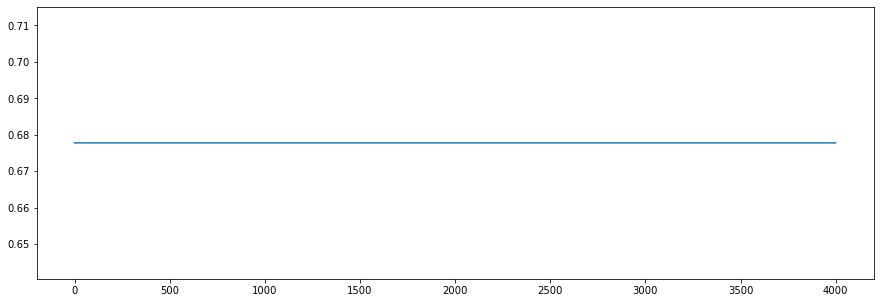

In [9]:
plt.figure(figsize = (15,5))
#plt.plot(V_test.cpu().detach().numpy()[16000:26000])
plt.plot(test_V_pred.flatten().cpu().detach().numpy()[16000:26000])

In [13]:
Z_out = np.zeros((25000,4))

for t in range(25000):
    for n in range(4):
        Z_out[t,n] = torch.argmax(test_Z_out[t,n])

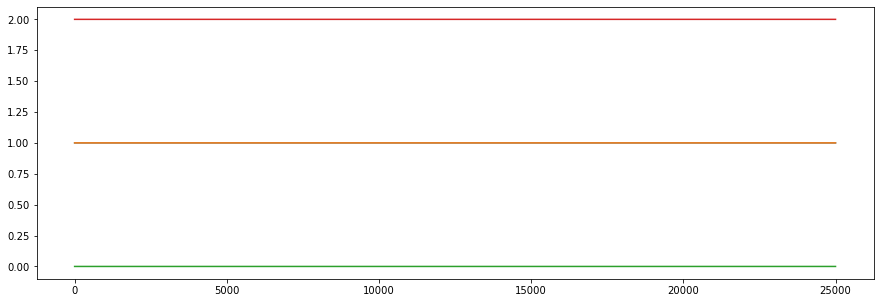

In [14]:
plt.figure(figsize = (15,5))

for n in range(4):
    plt.plot(Z_out[:,n])

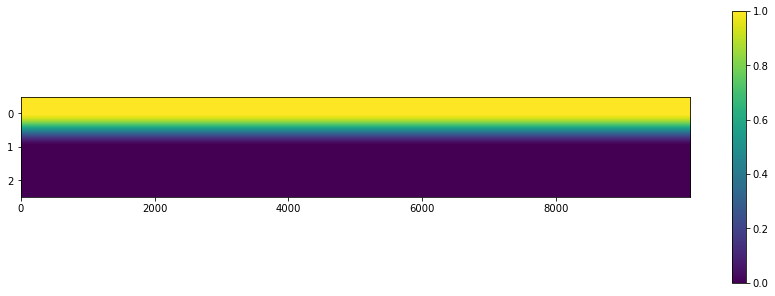

In [25]:
print()